**This notebook compiles the PySWMM pickle files, computes relevant metrics, and produces boxplots of input parameters vs. fvar**

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import numpy as np
import pandas as pd
import string
import plotly.graph_objects as go
from textwrap import wrap
import pickle
import glob
import os, sys
from pandas import *

#import custom functions
import functions
from functions import *

from os.path import dirname
parent_dir = (dirname(os.getcwd()))

In [2]:
# # set font properties
import matplotlib.font_manager as font_manager
from matplotlib.font_manager import FontProperties
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'16'}
sub_plot = {'fontname':'Arial', 'size':'18','color':'black', 
            'weight':'bold','horizontalalignment':'left', 'verticalalignment':'center'}
font_path = 'C:\Windows\Fonts\Arial.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=16)

In [3]:
#open soil pickle

with open('soil.pickle', 'rb') as handle:
    soil = pickle.load(handle)
    
# extract just soil texture to join to core below

soil['Soil_Texture']=soil['Soil Texture Class']
soil_tex=soil[['Soil_Texture']].reset_index()

In [4]:
#open and combine all PySWMM output pickles

path = 'out\\SCSTYPEII_ALL'
allFiles = glob.glob(path + "/*.pickle")
frame = pd.DataFrame()
list_ = []

for file_ in allFiles:
    with open(file_, 'rb') as handle:
        pickles = pickle.load(handle)
        frame = pd.DataFrame(pickles)
        list_.append(frame)
    temp = pd.concat(list_)
    core_temp=temp.reset_index().drop(['index'], axis=1)

In [5]:
#compute some metrics

core_temp['A']=core_temp['A2']+core_temp['A1']
core_temp['fV']=core_temp['A2']/core_temp['A']

for index,row in core_temp.iterrows():
    string = 'P='+str(row['P'])+'/'+'param='+str(row['param'])+'/'+'ASM='+str(row['ASM'])+'/'+'soil='+str(row['soil'])
    core_temp.at[index,'uniqueID']=string

core_temp['delta_inf']=core_temp['infiltration']-core_temp['infiltration_perv']
core_temp['IF']=core_temp['delta_inf']/(core_temp['runon'])

# convert to metric units, join with soil table

core_temp['IF']=core_temp['IF'].astype(float).round(3)
core_temp['f_var']=1-core_temp['IF']
core_temp['L']=core_temp['A']*43560/core_temp['W']
core_temp['L:W']=core_temp['L']/core_temp['W']
core_temp['Ks_mm']=(core_temp['Ks']*25.4).astype(float).round(1)
core_temp['P_cm']=(core_temp['P']*2.54).astype(float).round(1)
core_temp['H_i_cm']=(core_temp['H_i']*2.54).astype(float).round(1)
core_temp['IMD']=(core_temp['IMD']).astype(float).round(1)
core_temp['A_hec']=core_temp['A']*0.404686
core_temp['W_m']=core_temp['W']*0.3048
core_temp['L_m']=(core_temp['A_hec']/0.0001)/core_temp['W_m']
core_temp['A_check']=core_temp['W_m']*core_temp['L_m']*0.0001
core_temp['W_norm']=np.log(core_temp['W_m'])
core_temp=core_temp.merge(soil_tex, how='left',right_on='index',left_on='soil')

#extract relevant fields

core_temp=core_temp[['W_m','L:W','W','W_norm','A_hec','fV','S','P_cm','f_var','Ks_mm','ASM','Soil_Texture','H_i_cm']].copy()

In [6]:
# send to pickle

with open('out/CORE_ALL.pickle', 'wb') as handle:
    pickle.dump(core_temp, handle, protocol=pickle.HIGHEST_PROTOCOL)
    core = pd.DataFrame(core_temp)

#  sensitivity box plots

In [7]:
#bin continuous data

core_bins=bins(core)
core_bins['W_labls']=np.exp(core_bins['w_bins']).round(0)

In [8]:
# create table of max, min, std deviation of median f_var values across bins

cols=['Soil_Texture','fV_bins','a_bins','ASM','P_cm','W_labls','S']
feature_labels=['Soil Texture','$ɸ_P$','$A$','$ASM$','$P$','$W$','$S$']

min_t=dict()
max_t=dict()
std_t=dict()

for i,c in enumerate(cols):
    print(i,c)
    max_tab={}
    min_tab={}
    tab=core_bins[['f_var',c]]
    ma = tab.groupby([c]).median()
    max_tab=ma['f_var'].max()
    min_tab=ma['f_var'].min()
    std=ma['f_var'].std()
    # Adding a new key value pair
    min_t.update( {feature_labels[i] : min_tab} )
    max_t.update( {feature_labels[i] : max_tab} )
    std_t.update( {feature_labels[i] : std} )
    
min_table=pd.DataFrame.from_dict(min_t, orient='index').rename(columns={0: "min \n%s" % "\n".join(wrap("$ɸ_{var}$"))})
max_table=pd.DataFrame.from_dict(max_t, orient='index').rename(columns={0: "max \n%s" % "\n".join(wrap("$ɸ_{var}$"))})
std_table=pd.DataFrame.from_dict(std_t, orient='index').rename(columns={0: "std dev \n%s" % "\n".join(wrap("$ɸ_{var}$"))})

frames=[min_table,max_table,std_table]
min_max=pd.concat(frames,axis=1).astype(float).round(2)
min_max=min_max.reset_index().rename(columns={'index': "parameter"})
std_table=std_table.astype(float).round(2)
std_table=std_table.reset_index().rename(columns={'index': "parameter"})

0 Soil_Texture
1 fV_bins
2 a_bins
3 ASM
4 P_cm
5 W_labls
6 S


In [9]:
#wrap long labels 

core_bins['soil_wrap']=[ '\n'.join(wrap(l, 10)) for l in core_bins['Soil_Texture'] ]
core_bins['soil_wrap'].unique()

#make ASM categorical so it plots in teh right order

core_bins['ASM'] = pd.Categorical(core_bins['ASM'], ["SAT","FC","WP"])

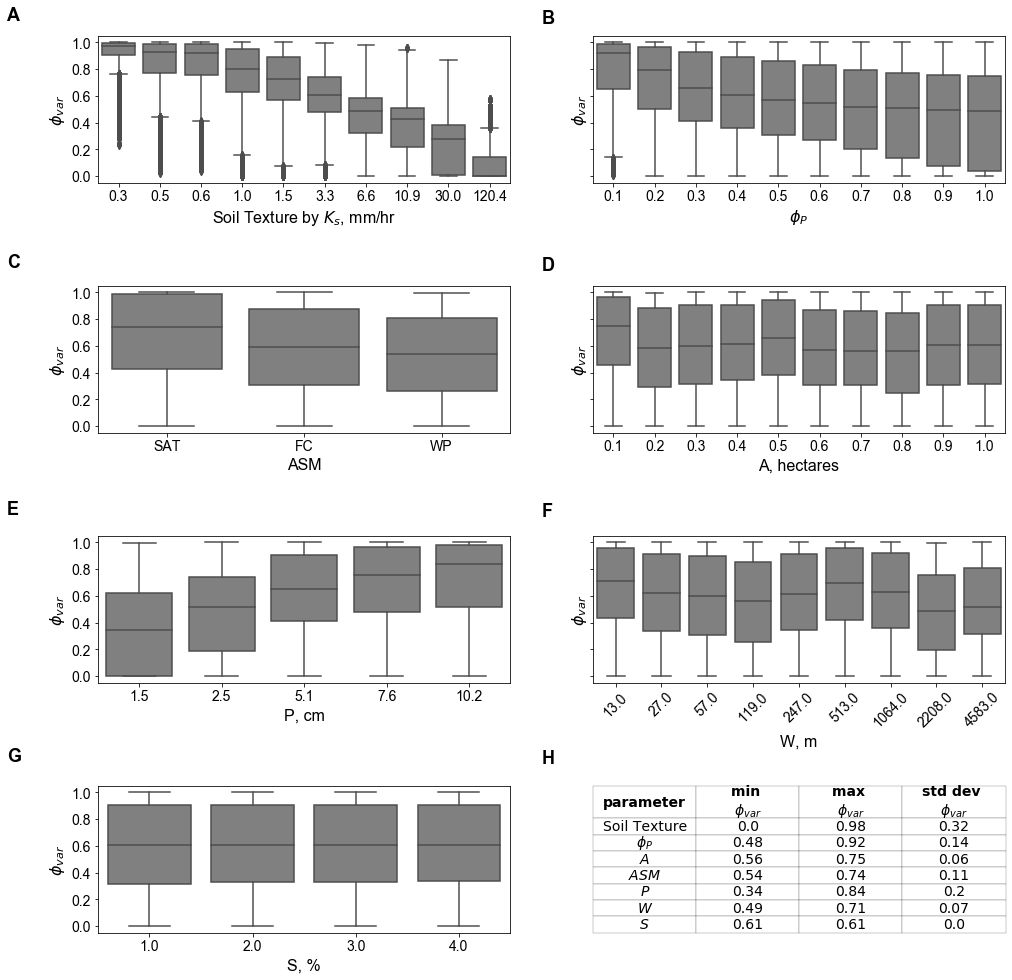

In [10]:
#box plots 

f, axes,ab=boxplots(4,2) 

sns.boxplot(x ='Ks_mm', y='f_var', data=core_bins, color='grey',ax=axes[0][0]).set(xlabel='Soil Texture by $K_s$, mm/hr',ylabel='$ɸ_{var}$')     
sns.boxplot(x ='ASM', y='f_var', data=core_bins, color='grey',ax=axes[1][0]).set(xlabel='ASM',ylabel='$ɸ_{var}$') 
sns.boxplot(x ='P_cm', y= 'f_var', data=core_bins,color='grey',ax=axes[2][0]).set(xlabel='P, cm',ylabel='$ɸ_{var}$') 
sns.boxplot(x ='S', y= 'f_var', data=core_bins,color='grey',ax=axes[3][0]).set(xlabel='S, %',ylabel='$ɸ_{var}$') 
sns.boxplot(x ='fV_bins', y='f_var', data=core_bins, color='grey',ax=axes[0][1]).set(xlabel='$ɸ_P$',ylabel='$ɸ_{var}$')  
sns.boxplot(x ='a_bins', y='f_var', data=core_bins, color='grey',ax=axes[1][1]).set(xlabel='A, hectares',ylabel='$ɸ_{var}$') 
sns.boxplot(x ='W_labls', y='f_var', data=core_bins, color='grey',ax=axes[2][1]).set(xlabel='W, m',ylabel='$ɸ_{var}$')
for tick in axes[2][1].get_xticklabels():
    tick.set_rotation(45)

axe = axes.ravel()
for a in axe:
    a.set_xlabel(a.get_xlabel(),**axis_font)
    a.set_ylabel(a.get_ylabel(),**axis_font)
    for label in (a.get_xticklabels() + a.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(14)  

#add table to axis 3,1
axes[3, 1].axis('off')
table=plt.table(cellText=min_max.values,
          colLabels=min_max.columns, 
          cellLoc = 'center', rowLoc = 'center', bbox=[0.001,.001,1.0,1.0])
for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

colLabels=min_max.columns
tab = [[5,2], [4,1], [4,1],[4,1], [4, 1],[4,1],[4,1]]

cellDict = table.get_celld()
for i in range(0,len(colLabels)):
    cellDict[(0,i)].set_height(1.8)
    for j in range(1,len(tab)+1):
        cellDict[(j,i)].set_height(0.9)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.2)
    cell.set_edgecolor('black')
    cell.set_fontsize(14)
axes[3][1].table

plt.savefig('sensitive.pdf',bbox_inches='tight')

**Figure 6.  Sensitivity of ϕvar to saturated soil texture and saturated hydraulic conductivity Ks (mm/hr) (panel A), pervious fraction ϕp  (panel B), antecedent soil moisture conditions ASM (SAT = saturated, FC = field capacity, WP = wilting point) (panel C), total area A (hectares) (panel D), precipitation depth P (cm) (panel E), width W (log normalized) (panel F), and slope S (%) (panel G). The middle line in each box plot represents the median ϕvar. S = Sand, LS= Loamy Sand, SL=Sandy Loam, SiL=Silt Loam, L= Loam, SCL =Sandy  Clay Loam, SiCL= Silty Clay Loam, SC=Sandy Clay, SiC= Silty Clay, C=Clay.**